In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from print_result import print_result, predict, convert_id2label, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd

In [4]:
MODELS = [
    {
        'model_name':"cardiffnlp/twitter-roberta-large-2022-154m",
        'model_path':"/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/finetuning_v2/cardiffnlp/twitter-roberta-large-2022-154m"
    },
    {
        'model_name': 'roberta-large',
        'model_path': '/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/finetuning_v2/roberta-large'
    },
    {
        'model_name': 'google/electra-large-discriminator',
        'model_path': '/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/finetuning_v2/google/electra-large-discriminator'
    },
    {
        'model_name':'tner/bertweet-large-tweetner7-all',
        'model_path':'/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/finetuning_v2/tner/bertweet-large-tweetner7-all'
    },
    {
        'model_name':'tner/roberta-large-tweetner7-all',
        'model_path':'/home/ubuntu/Profiling-Cryptocurrency-Influencers-with-FSL/finetuning_v2/tner/roberta-large-tweetner7-all'
    }
]

test_df = pd.read_csv('../data/finetune_train_val_test/test.csv')

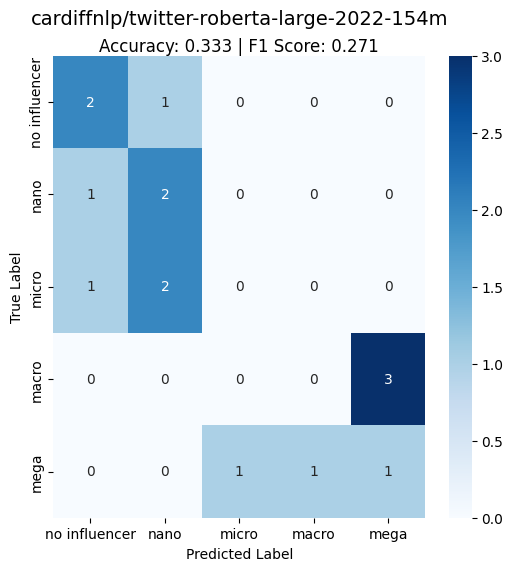

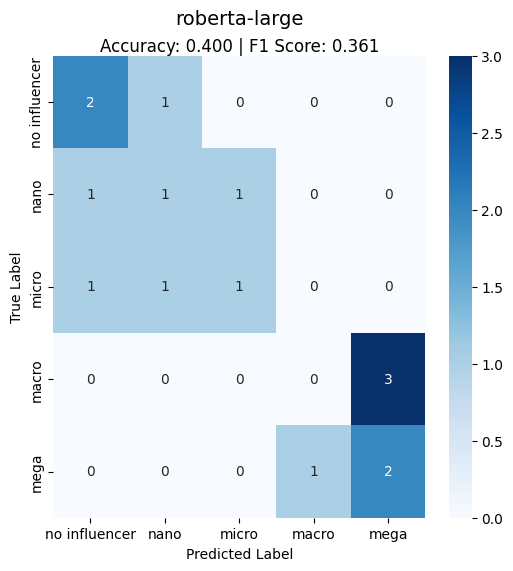

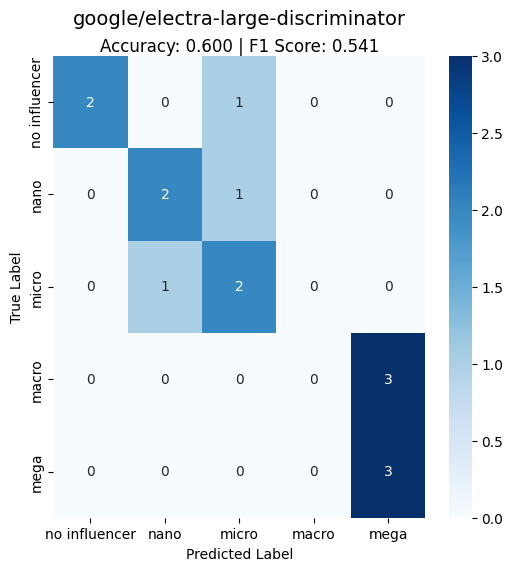

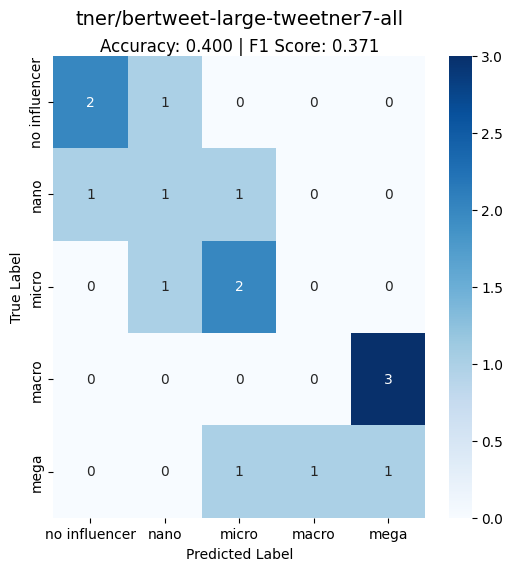

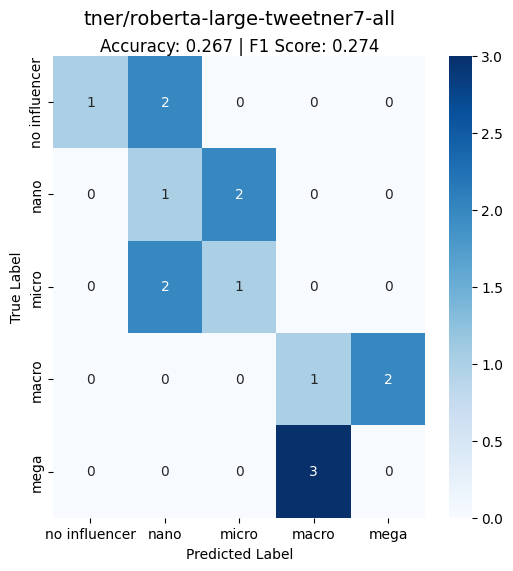

In [5]:
for d in MODELS:
    model_path = d['model_path']
    model_name = d['model_name']
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    test_df['predictions']=test_df['texts'].apply(lambda x: predict(x,model,tokenizer))
    test_df['actual'] = test_df['class'].apply(lambda x: convert_id2label(x))

    def majority_voting_with_tiebreaker(s):
        counts = s.value_counts()
        max_count = counts.max()
        tied_values = counts[counts == max_count].index
        if len(tied_values) > 1:
            # If there's a tie, average the values and round to the nearest integer
            return int(round(sum(tied_values) / len(tied_values)))
        else:
            return tied_values[0]

    # Group by 'twitter user id' and apply the custom aggregation function
    result = test_df.groupby('twitter user id').agg({
        'predictions': majority_voting_with_tiebreaker,
        'actual': 'first'
    }).reset_index()

    y_pred = result['predictions']
    y_true = result['actual']
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    plot_confusion_matrix(cm, ["no influencer", "nano", "micro", "macro", "mega"], acc, f1, model_name)